## Preparation

In [3]:
# Libraries 
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tf_utils
from time import time
from datetime import date
import json
import pathlib

In [16]:
# Parameters
EPOCHS = 50
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
SEED = 123

FPATH = 'C:/Users/User/Desktop/saved_models'

In [17]:
# Dataset preparation
train_part, valid_part, test_part = 0.7, 0.15, 0.15

# Loading
ds_kaggle = tf.keras.utils.image_dataset_from_directory(
    'kaggle dataset',
    validation_split=0,
    shuffle=True,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

nature_ds = tf.keras.utils.image_dataset_from_directory(
    'nature dataset',
    validation_split=0,
    shuffle=True,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = ds_kaggle.class_names
no_classes = len(class_names)

# Splitting
train_ds, valid_ds, test_ds = tf_utils.get_dataset_partitions(ds_kaggle, train_part, valid_part, test_part, seed=SEED)
print(f'Batches ({BATCH_SIZE} images per batch) in subsets:')
print(f'Train: {len(train_ds)}')
print(f'Validation: {len(valid_ds)}')
print(f'Test: {len(test_ds)}')

# Normalization
train_ds = train_ds.map(tf_utils.normalize)
valid_ds = valid_ds.map(tf_utils.normalize)
test_ds = test_ds.map(tf_utils.normalize)
nature_ds = nature_ds.map(tf_utils.normalize)

Found 10033 files belonging to 75 classes.
Found 138 files belonging to 75 classes.
Batches (32 images per batch) in subsets:
Train: 219
Validation: 47
Test: 48


## Fitting

In [14]:
# Constructing a model
name = 'VGG19'
# Loading pretrained convolutional layers of the model
pretrained = tf.keras.applications.VGG19(
    include_top=False,
    weights='imagenet',
    input_shape=(*IMG_SIZE, 3),
    pooling='max'
)

# Disabling training of pretrained layers
for layer in pretrained.layers:
    layer.trainable = False

# Creating the model - adding fully connected layers on top of model
model = tf.keras.models.Sequential(name=name)
model.add(pretrained)
model.add(tf.keras.layers.Dense(2048, activation='relu'))
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dense(no_classes, activation='softmax'))

# Compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

80134624/80134624 [==============================] - 4s 0us/step


In [18]:
t0 = time()

history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=valid_ds,
    steps_per_epoch=len(train_ds),
    validation_steps=len(valid_ds)
)

training_time = time() - t0
training_date = date.today()

Epoch 1/50
 50/219 [=====>........................] - ETA: 12:17 - loss: 4.3128 - accuracy: 0.0519

In [ ]:
model.save(f'{FPATH}/{model.name}_({training_date})/model')

tf_utils.plot_history(history)

json.dump(history.history, open(f'{FPATH}/{model.name}_({training_date})/history.json', 'w'))

In [ ]:
test_loss, test_accuracy = model.evaluate(test_ds)
print('Kaggle set evaluation: ')
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

In [ ]:
targets = []
predictions = []
for test_images, test_labels in test_ds.take(-1):
    targets.append(test_labels)
    predictions.append(model.predict(test_images))

m = tf_utils.confusion_matrix(predictions, targets, no_classes)
tf_utils.plot_confusion_matrix(m)
plt.show()

2/2 [==============================] - 12s 4s/step


AttributeError: module 'Auxiliary functions' has no attribute 'confusion_matrix'

In [ ]:
nature_test_loss, nature_test_accuracy = model.evaluate(nature_ds)
print('Nature set evaluation: ')
print(f'Test loss: {nature_test_loss}')
print(f'Test accuracy: {nature_test_accuracy}')

In [ ]:
targets = []
predictions = []
for test_images, test_labels in nature_ds.take(-1):
    targets.append(test_labels)
    predictions.append(model.predict(test_images))

nature_m = tf_utils.confusion_matrix(predictions, targets, no_classes)
tf_utils.plot_confusion_matrix(m)
plt.show()

In [ ]:
info = {
    'date': training_date,
    'duration': training_time,
    'name': model.name,
    'test_accuracy': test_accuracy,
    'test_loss': test_loss,
    'test_confusion': m,
    'nature_accuracy': nature_test_accuracy,
    'nature_loss': nature_test_loss,
    'nature_confusion': nature_m
    }

json.dump(info, open(f'{FPATH}/{model.name}_({training_date})/info.json', 'w'))

## Loaded

In [7]:
# Lookup model 
[print(i) for i in pathlib.Path(FPATH).glob('*')]

C:\Users\User\Desktop\saved_models\model1
C:\Users\User\Desktop\saved_models\model2
C:\Users\User\Desktop\saved_models\vgg1_pret


[None, None, None]

In [10]:
# Load model and data
model_dir = 'vgg1_pret'

model = tf.keras.models.load_model(f'{FPATH}/{model_dir}')

In [9]:
test_loss, test_accuracy = model.evaluate(test_ds)
print('Kaggle set evaluation: ')
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

25/25 [==============================] - 182s 7s/step - loss: 0.0207 - accuracy: 0.9950
Kaggle set evaluation: 
Test loss: 0.020665638148784637
Test accuracy: 0.9950000047683716


2/2 [==============================] - 7s 4s/step


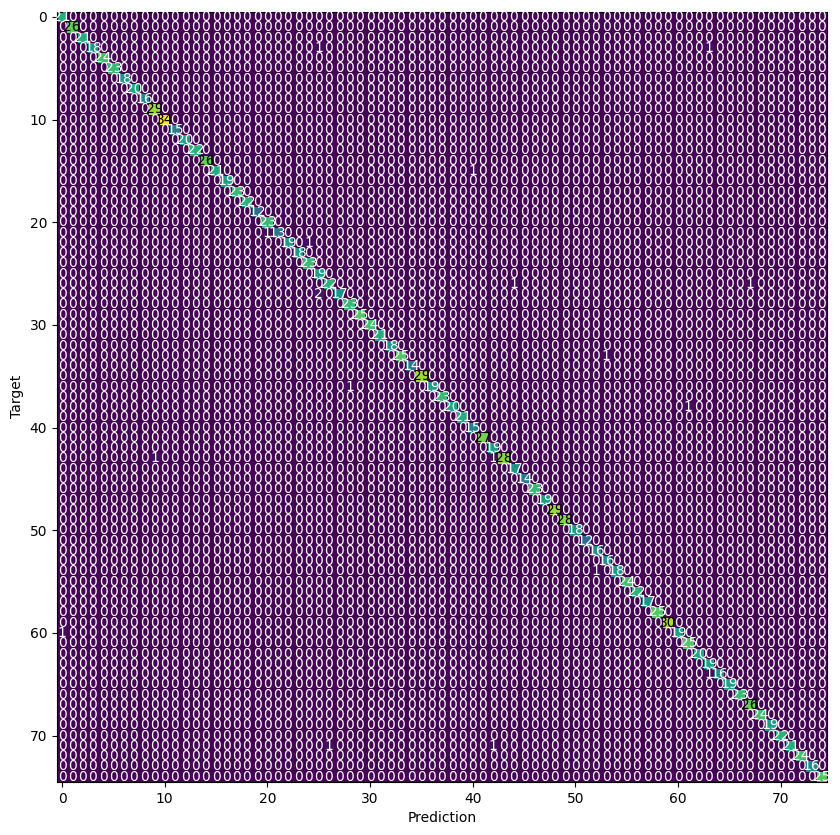

In [10]:
targets = []
predictions = []
for test_images, test_labels in test_ds.take(-1):
    targets.append(test_labels)
    predictions.append(model.predict(test_images))

m = tf_utils.confusion_matrix(predictions, targets, no_classes)
tf_utils.plot_confusion_matrix(m)
plt.show()

In [11]:
nature_test_loss, nature_test_accuracy = model.evaluate(nature_ds)
print('Nature set evaluation: ')
print(f'Test loss: {nature_test_loss}')
print(f'Test accuracy: {nature_test_accuracy}')

3/3 [==============================] - 17s 4s/step - loss: 2.8614 - accuracy: 0.7174
Nature set evaluation: 
Test loss: 2.861356735229492
Test accuracy: 0.717391312122345


1/1 [==============================] - 1s 1s/step


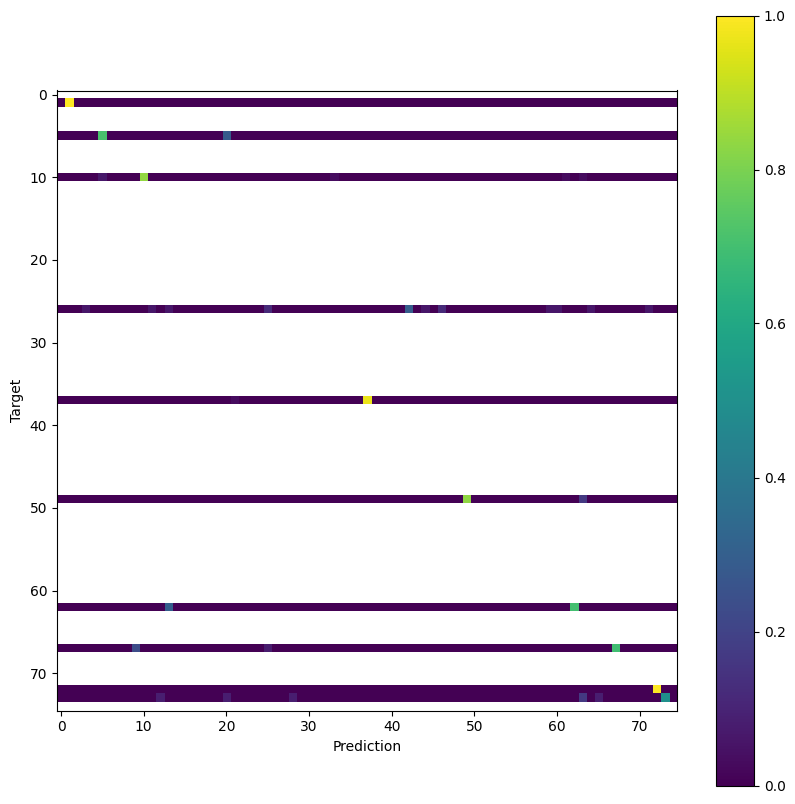

In [13]:
targets = []
predictions = []
for test_images, test_labels in nature_ds.take(-1):
    targets.append(test_labels)
    predictions.append(model.predict(test_images))

nature_m = tf_utils.confusion_matrix(predictions, targets, no_classes)
tf_utils.plot_confusion_matrix(nature_m)
plt.show()

In [ ]:
info = {
    'date': training_date,
    'duration': training_time,
    'name': model.name,
    'test_accuracy': test_accuracy,
    'test_loss': test_loss,
    'test_confusion': m,
    'nature_accuracy': nature_test_accuracy,
    'nature_loss': nature_test_loss,
    'nature_confusion': nature_m
    }

json.dump(info, open(f'{FPATH}/{model.name}_({training_date})/info.json', 'w'))